<a href="https://colab.research.google.com/github/Madhugogula/Assignment/blob/main/Group1ProjectFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def fetch_data(ticker,start_date,end_date):
  import yfinance as yf
  from datetime import datetime, timedelta

  data = pd.DataFrame(index=pd.bdate_range(start=start_date,end=end_date))

  data['day_of_year'] = data.index.day_of_year
  data['month'] = data.index.month
  data['year'] = data.index.strftime('%Y')

  end_date1 = datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))+timedelta(days=1)
  fetched_data = yf.download(tickers=ticker,start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')
  data = data.join(fetched_data)

  data['oil_Close'] = yf.download(tickers="CL=F",start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')['Close']
  data['NIFTY50_Close'] = yf.download(tickers="^NSEI",start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')['Close']

  data.fillna(method='ffill',inplace=True) #filling up missing dates
  return data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

import xgboost
from xgboost import XGBRegressor, plot_importance, plot_tree

from hyperopt import hp
from scipy.stats import uniform, randint

In [ ]:
start_date = '2013-01-01'
end_date = '2023-06-15'
data = fetch_data("RELIANCE.NS",start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,day_of_year,month,year,Open,High,Low,Close,Adj Close,Volume,oil_Close,NIFTY50_Close
2013-01-01,1,1,2013,418.037415,419.325226,415.610443,416.402924,387.885162,3152667.0,NaN,NaN
2013-01-02,2,1,2013,418.037415,423.981079,417.319244,419.993866,391.230194,6203434.0,93.120003,5993.250000
2013-01-03,3,1,2013,420.315826,426.952911,418.334595,426.333771,397.135895,7968629.0,92.919998,6009.500000
2013-01-04,4,1,2013,426.903381,428.240692,422.767578,426.878632,397.643433,6140890.0,93.089996,6016.149902
2013-01-07,7,1,2013,428.785553,431.410645,421.900787,424.278259,395.221161,7064261.0,93.190002,5988.399902
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,160,6,2023,2507.000000,2508.550049,2478.000000,2481.949951,2481.949951,2712243.0,70.169998,18563.400391
2023-06-12,163,6,2023,2475.500000,2489.199951,2465.000000,2484.149902,2484.149902,2949893.0,67.120003,18601.500000
2023-06-13,164,6,2023,2495.000000,2523.449951,2486.250000,2520.850098,2520.850098,5190958.0,69.419998,18716.150391
2023-06-14,165,6,2023,2521.000000,2555.000000,2517.000000,2551.850098,2551.850098,6127509.0,68.269997,18755.900391


In [ ]:
pre_covid = data[:'2020-02-29'].copy()

In [ ]:
post_covid = data['2020-09-01':].copy()

# Model Building

#### **Investigate or add your own model here, Use same error function to evaluate**

In [ ]:
def prediction_error(test_data, pred_data):
  print('RMSE:',np.sqrt(mean_squared_error(test_data,pred_data)))

## LSTM
*by Pavan*

In [ ]:
data1 = data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data1.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))
print(training_data_len)

2592


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01485096],
       [0.01632285],
       [0.01892151],
       ...,
       [0.87744288],
       [0.89014947],
       [0.89043637]])

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.01485096, 0.01632285, 0.01892151, 0.01914485, 0.01807898,
       0.01687101, 0.01728721, 0.0167492 , 0.01468854, 0.01624164,
       0.01616043, 0.01904332, 0.02485987, 0.02693068, 0.03094033,
       0.03096063, 0.0315697 , 0.03004705, 0.02936693, 0.02639268,
       0.02340828, 0.02676827, 0.02417975, 0.02567195, 0.0241899 ,
       0.02176381, 0.02194653, 0.02138822, 0.01948998, 0.02047463,
       0.02190593, 0.02262665, 0.01796733, 0.01588637, 0.0162315 ,
       0.01641421, 0.02177396, 0.01860684, 0.0192971 , 0.01762218,
       0.011359  , 0.01294256, 0.00939985, 0.00869943, 0.00914607,
       0.01193761, 0.01374449, 0.01399827, 0.01700297, 0.01562243,
       0.01630255, 0.01572394, 0.0187794 , 0.01544987, 0.01355163,
       0.01166353, 0.01119659, 0.00914607, 0.00874003, 0.00846595])]
[0.003207719742393228]

[array([0.01485096, 0.01632285, 0.01892151, 0.01914485, 0.01807898,
       0.01687101, 0.01728721, 0.0167492 , 0.01468854, 0.01624164,
       0.01616043, 0.01904332, 0.0

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2532/2532 [==============================] - 114s 44ms/step - loss: 0.0018


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


# Convert the data to a numpy array
x_test = np.array(x_test)


# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

136
5/5 [==============================] - 0s 37ms/step


In [ ]:
prediction_error(y_test,predictions)

RMSE: 68.11833304938924


<ipython-input-16-bac245597b66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


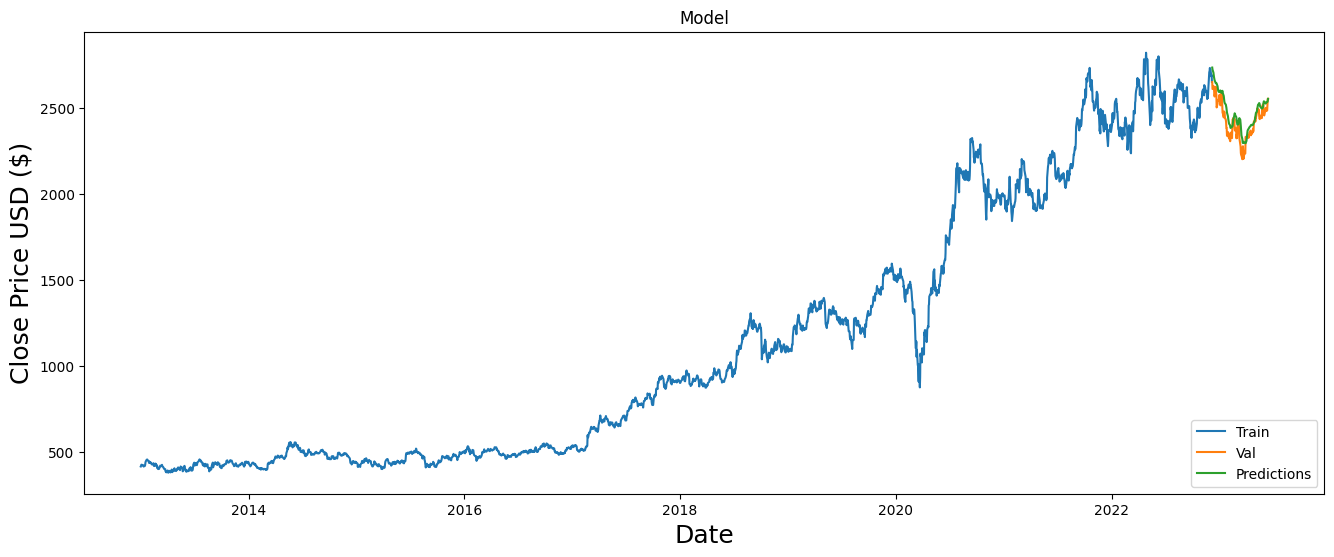

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid.index

DatetimeIndex(['2022-12-08', '2022-12-09', '2022-12-12', '2022-12-13',
               '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-19',
               '2022-12-20', '2022-12-21',
               ...
               '2023-06-02', '2023-06-05', '2023-06-06', '2023-06-07',
               '2023-06-08', '2023-06-09', '2023-06-12', '2023-06-13',
               '2023-06-14', '2023-06-15'],
              dtype='datetime64[ns]', length=136, freq='B')

In [ ]:
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 13 not upgraded.
Need to get 7,697 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1 amd64 1:1.1.0-1 [65.3 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-xkb-utils amd64 7.7+5 [158 kB]
Get:5 http://archive.ubuntu.com/ubunt

In [ ]:
from tkinter import *
from tkinter import messagebox
from decimal import *
import tkinter
top = tkinter()
top.geometry("600x650")
title=Label(top,text="Liver Cirrhosis Prediction",font=("Arial",25))
title.place(x=100,y=0)
na=Entry(top)
na.place(x=250,y=50)
top.mainloop()

TypeError: ignored

In [ ]:
a=np.array([[251,12,2023,2646.000000,2660.000000,2601.850098,2609.100098,2609.100098,5840633.0,71.019997,18496.599609,2721.847168]])

NameError: ignored

In [ ]:
# Show the valid and predicted prices
valid

,day_of_year,month,year,Open,High,Low,Close,Adj Close,Volume,oil_Close,NIFTY50_Close,Predictions
2022-12-08,342,12,2022,2660.000000,2665.000000,2640.100098,2649.250000,2649.250000,3579858.0,71.459999,18609.349609,2733.639404
2022-12-09,343,12,2022,2646.000000,2660.000000,2601.850098,2609.100098,2609.100098,5840633.0,71.019997,18496.599609,2721.847168
2022-12-12,346,12,2022,2585.500000,2623.000000,2585.000000,2613.100098,2613.100098,4374946.0,73.169998,18497.150391,2704.859375
2022-12-13,347,12,2022,2613.100098,2633.000000,2606.699951,2625.000000,2625.000000,3845839.0,75.389999,18608.000000,2689.174561
2022-12-14,348,12,2022,2637.649902,2638.949951,2611.000000,2615.500000,2615.500000,3354618.0,77.279999,18660.300781,2678.567627
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,160,6,2023,2507.000000,2508.550049,2478.000000,2481.949951,2481.949951,2712243.0,70.169998,18563.400391,2531.291504
2023-06-12,163,6,2023,2475.500000,2489.199951,2465.000000,2484.149902,2484.149902,2949893.0,67.120003,18601.500000,2533.259521
2023-06-13,164,6,2023,2495.000000,2523.449951,2486.250000,2520.850098,2520.850098,5190958.0,69.419998,18716.150391,2534.177979
2023-06-14,165,6,2023,2521.000000,2555.000000,2517.000000,2551.850098,2551.850098,6127509.0,68.269997,18755.900391,2539.991699


## LSTM
*by Anjali*

In [ ]:
df = post_covid[['Close']].copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
df.shape

(728, 1)

In [ ]:
## splitting dataset into train and test split
training_size = int(len(df)*0.65)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:1]
print(len(train_data),len(test_data))

473 255


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3, and t+4
time_step = 80
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
y_test[0:4]

array([0.54069938, 0.57960933, 0.6230698 , 0.66668356])

In [ ]:
## reshape input to be [samples, time steps, features] which is requires for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
## Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(80,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 80, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 80, 50)            20200     
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 10s 396ms/step - loss: 0.1494 - val_loss: 0.1133
Epoch 2/100
7/7 [==============================] - 1s 175ms/step - loss: 0.0417 - val_loss: 0.0352
Epoch 3/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0321 - val_loss: 0.0120
Epoch 4/100
7/7 [==============================] - 2s 268ms/step - loss: 0.0152 - val_loss: 0.0127
Epoch 5/100
7/7 [==============================] - 2s 267ms/step - loss: 0.0154 - val_loss: 0.0076
Epoch 6/100
7/7 [==============================] - 1s 175ms/step - loss: 0.0132 - val_loss: 0.0060
Epoch 7/100
7/7 [==============================] - 1s 171ms/step - loss: 0.0124 - val_loss: 0.0061
Epoch 8/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0110 - val_loss: 0.0061
Epoch 9/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0108 - val_loss: 0.0061
Epoch 10/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0105 - val_loss: 0.0055
Epoch 11

In [ ]:
## Lets do the prediction and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

6/6 [==============================] - 0s 35ms/step


In [ ]:
y_test = y_test.reshape(len(y_test),1)
y_train = y_train.reshape(len(y_train),1)

In [ ]:
## Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [ ]:
prediction_error(y_test,test_predict)

RMSE: 48.43855480422883


In [ ]:
## shift train predictions for plotting
look_back = 80
## shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+160+1:len(df)-1,:] = test_predict

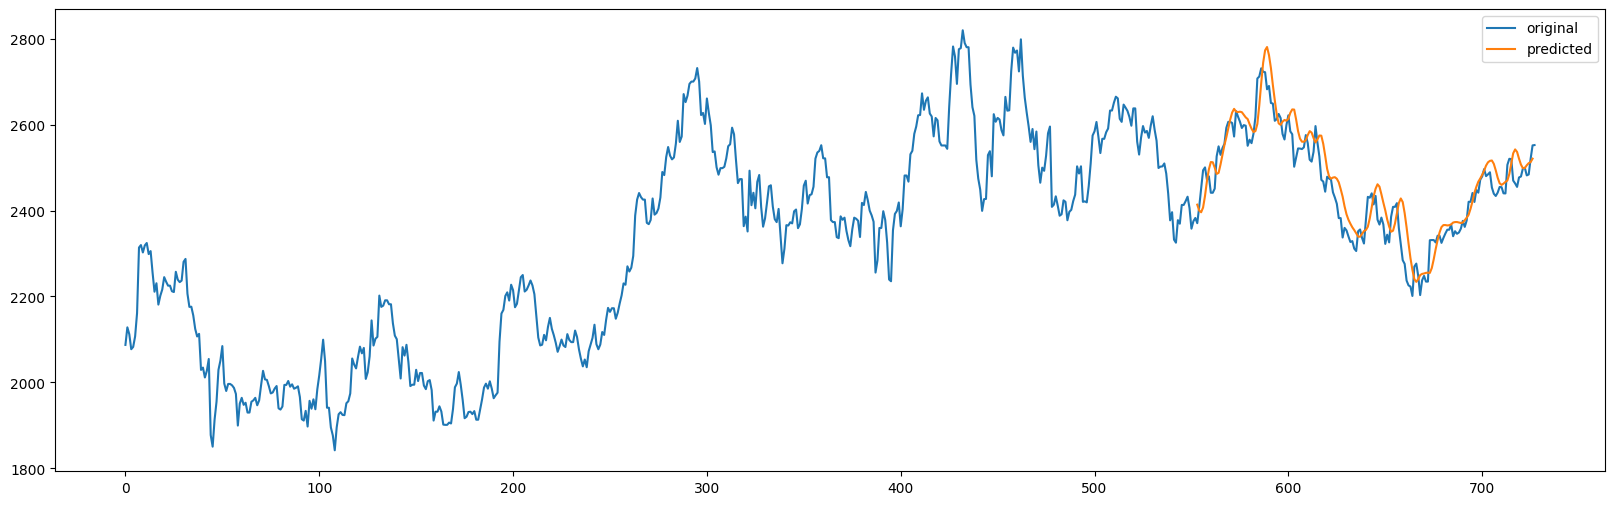

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(df),label="original")
plt.plot(testPredictPlot,label="predicted")
plt.legend()

In [ ]:
len(test_data)

255

In [ ]:
test_data

array([[0.6729727 ],
       [0.66540531],
       [0.70124747],
       [0.75488275],
       [0.77073304],
       [0.57955815],
       [0.58467115],
       [0.60466301],
       [0.58277949],
       [0.55849275],
       [0.56186713],
       [0.59510161],
       [0.59157369],
       [0.54770428],
       [0.56774708],
       [0.57250231],
       [0.59341442],
       [0.60860012],
       [0.67598931],
       [0.65891196],
       [0.67609167],
       [0.59152251],
       [0.59264747],
       [0.59029544],
       [0.62905211],
       [0.68258503],
       [0.74946317],
       [0.75948445],
       [0.78167505],
       [0.74644631],
       [0.70768989],
       [0.74158896],
       [0.74158896],
       [0.75728596],
       [0.76608041],
       [0.80892722],
       [0.80892722],
       [0.82764084],
       [0.84180369],
       [0.83786683],
       [0.78934455],
       [0.7819307 ],
       [0.82303914],
       [0.81582977],
       [0.8079558 ],
       [0.79358823],
       [0.77277824],
       [0.813

In [ ]:
x_test.shape

(174, 80, 1)

In [ ]:
x_input = test_data[175:].reshape(1,-1)
x_input.shape

(1, 80)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.5539931678583259,
 0.5377851188334779,
 0.4914613208557579,
 0.513293666000995,
 0.4950404183869146,
 0.5557315367275673,
 0.579558150223731,
 0.579558150223731,
 0.5884037839169796,
 0.5289906650365663,
 0.4916146108867381,
 0.4525513677640054,
 0.4438080938634308,
 0.4040290811660727,
 0.3926269492362835,
 0.38976387093778286,
 0.3674199764872068,
 0.4374168482720793,
 0.44447293319974945,
 0.41502202358319695,
 0.36951635497277624,
 0.40454038081338095,
 0.4152264935105141,
 0.4016258729605122,
 0.4016258729605122,
 0.5001534148599955,
 0.5005623547146298,
 0.5005623547146298,
 0.49483594845959744,
 0.5107883476607917,
 0.5107883476607917,
 0.49381334916498143,
 0.5055732410530676,
 0.5161058140611898,
 0.5251559176817555,
 0.5251559176817555,
 0.5373759293208129,
 0.5096636382315325,
 0.5215768201505988,
 0.5154924042792384,
 0.5185090222667503,
 0.5277124159182958,
 0.5461703831177245,
 0.5319051728894346,
 0.5471929824123409,
 0.5916248718318082,
 0.5916248718318082,
 0.612639

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=80
i=0
while(i<30):

    if(len(temp_input)>80):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.73203033]
81
1 day input [0.53778512 0.49146132 0.51329367 0.49504042 0.55573154 0.57955815
 0.57955815 0.58840378 0.52899067 0.49161461 0.45255137 0.44380809
 0.40402908 0.39262695 0.38976387 0.36741998 0.43741685 0.44447293
 0.41502202 0.36951635 0.40454038 0.41522649 0.40162587 0.40162587
 0.50015341 0.50056235 0.50056235 0.49483595 0.51078835 0.51078835
 0.49381335 0.50557324 0.51610581 0.52515592 0.52515592 0.53737593
 0.50966364 0.52157682 0.5154924  0.51850902 0.52771242 0.54617038
 0.53190517 0.54719298 0.59162487 0.59162487 0.61263934 0.59121593
 0.61974635 0.61335511 0.64418638 0.65200941 0.66944478 0.65277636
 0.65691794 0.66192857 0.62567748 0.61084979 0.60548114 0.61355958
 0.62690455 0.62644443 0.61182121 0.61151438 0.67956841 0.69398716
 0.69332232 0.64214118 0.63534099 0.62710902 0.64965738 0.65180494
 0.67102961 0.67256351 0.65446355 0.65671322 0.69424281 0.72594339
 0.72665916 0.73203033]
1 day output [[0.7503542]]
2 day input [0.49146132 0.51329367 0.49504042 0.55

In [ ]:
day_new=np.arange(1,81)
day_pred=np.arange(81,111)

In [ ]:
day_new

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [ ]:
day_pred

array([ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110])

In [ ]:
len(df)

728

In [ ]:
728-81

647

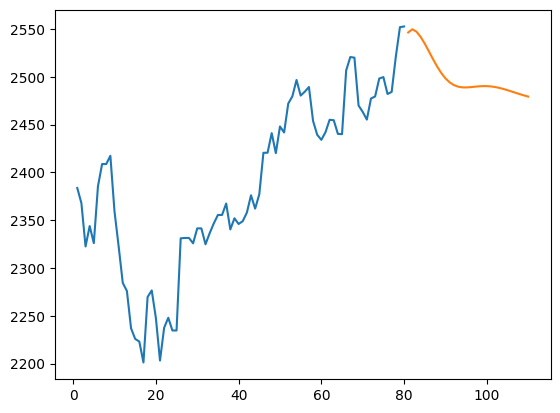

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df[648:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

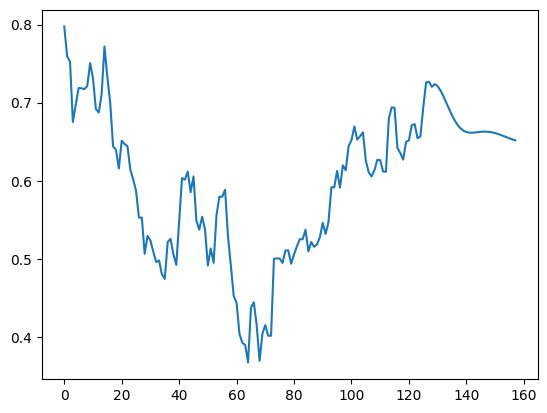

In [ ]:
df1=df.tolist()
df1.extend(lst_output)
plt.plot(df1[600:])

In [ ]:
df1=scaler.inverse_transform(df1).tolist()

In [ ]:
len(df1)

758

In [ ]:
len(new_data)

699

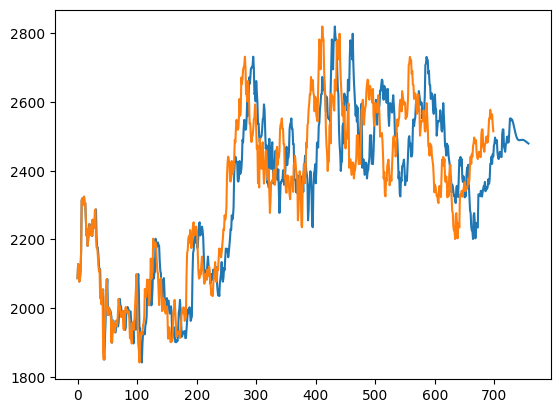

In [ ]:
plt.plot(df1)
plt.plot(new_data)

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
new_data = yf.download(tickers="RELIANCE.NS",start="2020-09-01",end="2023-06-25",period='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
new_data = new_data[['Close']].copy()

In [ ]:
new_data =np.array(new_data).reshape(-1,1)


In [ ]:
new_data

[array([[2087.25      ],
        [2128.19995117],
        [2112.10009766],
        [2077.25      ],
        [2082.64990234],
        [2107.10009766],
        [2161.35009766],
        [2314.        ],
        [2319.75      ],
        [2302.55004883],
        [2318.85009766],
        [2324.55004883],
        [2298.75      ],
        [2305.69995117],
        [2255.85009766],
        [2211.14990234],
        [2230.80004883],
        [2181.19995117],
        [2201.69995117],
        [2216.25      ],
        [2245.05004883],
        [2234.35009766],
        [2225.25      ],
        [2212.19995117],
        [2210.35009766],
        [2257.5       ],
        [2239.25      ],
        [2233.44995117],
        [2237.05004883],
        [2280.69995117],
        [2287.5       ],
        [2206.5       ],
        [2175.80004883],
        [2176.19995117],
        [2155.89990234],
        [2124.60009766],
        [2106.94995117],
        [2113.05004883],
        [2029.09997559],
        [2034.5       ],


In [ ]:
df1

[[2087.25],
 [2128.199951171875],
 [2112.10009765625],
 [2077.25],
 [2082.64990234375],
 [2107.10009765625],
 [2161.35009765625],
 [2314.0],
 [2319.75],
 [2302.550048828125],
 [2318.85009765625],
 [2324.550048828125],
 [2298.75],
 [2305.699951171875],
 [2255.85009765625],
 [2211.14990234375],
 [2230.800048828125],
 [2181.199951171875],
 [2201.699951171875],
 [2216.25],
 [2245.050048828125],
 [2234.35009765625],
 [2225.25],
 [2225.25],
 [2212.199951171875],
 [2210.35009765625],
 [2257.5],
 [2239.25],
 [2233.449951171875],
 [2237.050048828125],
 [2280.699951171875],
 [2287.5],
 [2206.5],
 [2175.800048828125],
 [2176.199951171875],
 [2155.89990234375],
 [2124.60009765625],
 [2106.949951171875],
 [2113.050048828125],
 [2029.0999755859373],
 [2034.5],
 [2011.449951171875],
 [2026.9000244140627],
 [2054.5],
 [1877.449951171875],
 [1850.4000244140625],
 [1913.199951171875],
 [1955.0],
 [2029.1500244140623],
 [2050.699951171875],
 [2084.550048828125],
 [1997.199951171875],
 [1980.0],
 [1996.40

## XGBOOST
*by Pavan*

In [ ]:
stock_day = data.asfreq('D', method ='pad')

In [ ]:
def train_data(data):
    x = data['Close']
    X_train = []
    y_train = []
    for i in range(60, 2870):
        X_train.append(x[i-60:i])
        y_train.append(x[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

def test_data(data):
    x = data['Close'][len(data['Close'])-182:]
    X_test = []
    y_test = []
    for i in range(60, 182):
        X_test.append(x[i-60:i])
        y_test.append(x[i])
    X_test, y_test = np.array(X_test), np.array(y_test)
    return X_test, y_test

In [ ]:
# performing
X_train, y_train = train_data(stock_day)

X_test, y_test = test_data(stock_day)

# shape of the input and output
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2810, 60), (2810,), (122, 60), (122,))

In [ ]:
xgb = xgboost.XGBRegressor(random_state = 101)
# Traing and  Evaluate model on train/test set
xgb.fit(X_train, y_train)
prediction = xgb.predict(X_test)

In [ ]:
prediction_error(y_test,prediction)

RMSE: 184.54869423605837


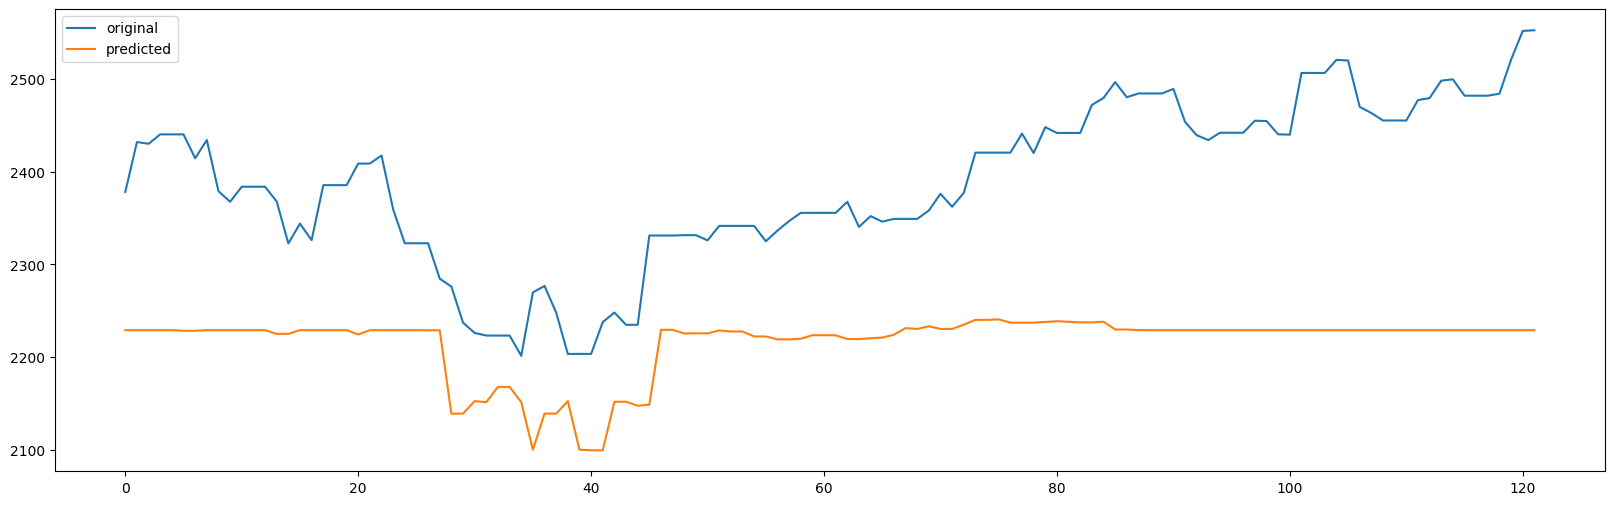

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(y_test,label="original")
plt.plot(prediction,label="predicted")
plt.legend()

## XGBoost
*by Aniket*

In [ ]:
data2 = data[['Close']].copy()

data2['target'] = data2['Close'].shift(-1)
data2.dropna(inplace=True)
data2.head()

,Close,target
2013-01-01,416.402924,419.993866
2013-01-02,419.993866,426.333771
2013-01-03,426.333771,426.878632
2013-01-04,426.878632,424.278259
2013-01-07,424.278259,421.331207


In [ ]:
train = data2.iloc[:-30]
test = data2.iloc[-30:]
print(train.shape, test.shape)

(2697, 2) (30, 2)


In [ ]:
def xgb_predict(train,test):
  train_matrix, test_matrix = train.to_numpy(), test.to_numpy()
  test_x, test_y = test_matrix[:,:-1], test_matrix[:,1]
  pred = np.empty(shape=len(test_y))
  for i in range(len(test_y)):
    train_x, train_y = train_matrix[:,:-1], train_matrix[:,1]
    xgb = XGBRegressor()
    xgb.fit(train_x,train_y)
    pred[i] = xgb.predict(test_x[i])
    train_matrix = np.append(train_matrix,[test_matrix[i]],axis=0)
  return pred

In [ ]:
y_pred = pd.Series(xgb_predict(train,test),index=test.index)

In [ ]:
prediction_error(test['target'],y_pred)

RMSE: 31.660279247994964


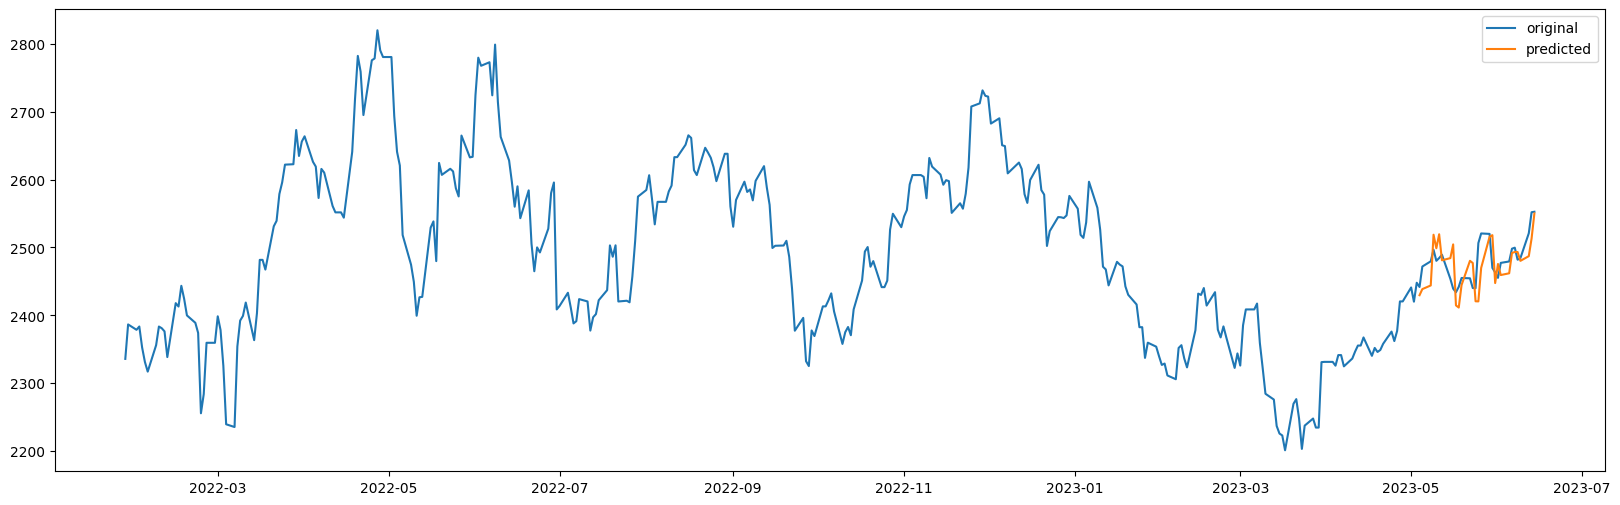

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(data2['target'][-360:],label="original")
plt.plot(y_pred,label="predicted")
plt.legend()